In [1]:
"""
Takes raw exports from Realsense export tool and Cepton pcap conversion tool
Renames files and matches them based on timestamp. Does not modify source directory
Inputs:
    <date>/
        Camera/
            _Color_xxx.png
            ...
        Lidar/
            xxx.pcd
            ...
        <gpsfile>.ubx
            
Outputs:
    Export/
        image_00/
            Data/
                0000000001.png
                ...
            timestamps.txt
        pointcloud/
            Data/
                0000000001.pcd
                ...
            timestamps.txt

Calibration and GPS data are currently handled separately
"""

import os
from os import listdir
from os.path import isfile, join
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
from pyubx2 import ERR_IGNORE, GET, POLL, SET, UBXReader

"""
Hardcoded path information
"""
date = "2024-05-09"
origin_path = "../DriveData/" + date
cam_origin = origin_path + "/Camera/"
lidar_origin = origin_path + "/Lidar/"

dest_path = origin_path + "/Export/"
cam_dest = dest_path + 'image_00/'
lidar_dest = dest_path + 'pointcloud/'
gps_dest = dest_path + 'oxts/'

gps_file = origin_path + '/COM3___9600_240509_033217.ubx'
imu_file = origin_path + ''

#TODO: Remove hardcoded filepaths
#TODO: Confirm whether dataset exists and if desired skip parts of generation

ModuleNotFoundError: No module named 'pandas'

In [4]:
"""
Create dataframe of raw camera frame metadata from frame filename. [Epoch, Datetime, Filepath]
"""

temp_data = []
cam_dataframe = pd.DataFrame()
# Grab all files in the camera folder
cam_files = [f for f in listdir(cam_origin) if isfile(join(cam_origin, f))]
cam_files.sort()

# Rename and copy files
for file_name in cam_files:
    # If the file is not metadata
    if ('metadata' in  file_name) == False:
        # Copy to working directory
        # shutil.copy(cam_origin + file_name, cam_temp + file_name)

        # Get epoch from filename
        trimmedname = file_name.split('_')
        parts = trimmedname[2].split('.')

        #os.rename(cam_temp + file_name, cam_temp + parts[0] + '.' + parts[2])

        # Append data to frame
        temp_dict = { 'Epoch' : float(parts[0] + '.' + parts[1]), 
                     'Datetime' : pd.to_datetime(float(parts[0] + '.' + parts[1]),unit='ms'),
                     'camera_path' : file_name }
        
        temp_data.append(temp_dict)

# Keep list of new camera frames
#cam_data['Datetime'] = pd.to_datetime(cam_data['Epoch'])
cam_dataframe = pd.DataFrame(temp_data)
cam_dataframe.head()

,Epoch,Datetime,camera_path
0,1.715226e+12,2024-05-09 03:33:58.223291016,_Color_1715225638223.29101562500000.png
1,1.715226e+12,2024-05-09 03:33:58.290006104,_Color_1715225638290.00610351562500.png
2,1.715226e+12,2024-05-09 03:33:58.356722168,_Color_1715225638356.72216796875000.png
3,1.715226e+12,2024-05-09 03:33:58.423437256,_Color_1715225638423.43725585937500.png
4,1.715226e+12,2024-05-09 03:33:58.490152100,_Color_1715225638490.15209960937500.png


In [5]:
"""
Create dataframe of lidar metadata from filenames
"""

lidar_dataframe = pd.DataFrame()
temp_data = []
# grab all files in the lidar folder
lidar_files = [f for f in listdir(lidar_origin) if isfile(join(lidar_origin, f))]
lidar_files.sort()

for file_name in lidar_files:
    # Save original timestamp
    time = float(file_name[:13] + '.' + file_name[13:16])
    temp_dict = { 'Epoch' : time,
                 'Datetime' : pd.to_datetime(time,unit='ms'),
                 'lidar_path' : file_name
    }
    temp_data.append(temp_dict)
    
    # rename them to match camera format
    #shutil.copy(lidar_origin + file_name, lidar_temp + file_name)
    #os.rename(lidar_temp + file_name, lidar_temp + file_name[:13] + '.pcd')
temp_data.pop()

lidar_dataframe = pd.DataFrame(temp_data)
lidar_dataframe.head()

,Epoch,Datetime,lidar_path
0,1.715226e+12,2024-05-09 03:32:28.525175049,1715225548525175.pcd
1,1.715226e+12,2024-05-09 03:32:28.625275879,1715225548625276.pcd
2,1.715226e+12,2024-05-09 03:32:28.725679932,1715225548725680.pcd
3,1.715226e+12,2024-05-09 03:32:28.826284912,1715225548826285.pcd
4,1.715226e+12,2024-05-09 03:32:28.926818115,1715225548926818.pcd


In [6]:
"""
Compute statistcis from timestamps and plot
"""
# Compute time between camera frames
cam_dataframe['camera_frame_deltas'] = cam_dataframe['Epoch'].diff()

#Compute time between lidar frames
lidar_dataframe['lidar_frame_deltas'] = lidar_dataframe['Epoch'].diff()

Number of cam frames: 5987, Average time delta: 66.71917004749363


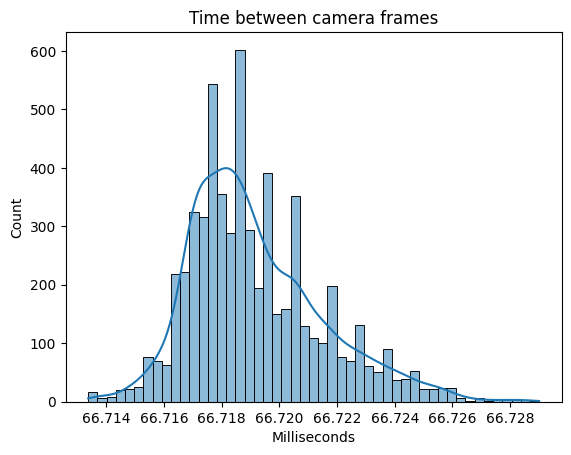

In [8]:
# Plot camera timestamp delat distribution
plot = sns.histplot(pd.Series(cam_dataframe['camera_frame_deltas'], name = "Milliseconds"), kde=True).set_title("Time between camera frames")
figure = plot.get_figure()
figure.savefig("TimeBTCamFrames.svg")
print("Number of cam frames: " + str(len(cam_dataframe.index)) + ", Average time delta: " + str(cam_dataframe['camera_frame_deltas'].mean()))

Number of lidar frames: 4731, Average time delta: 100.37014820832783


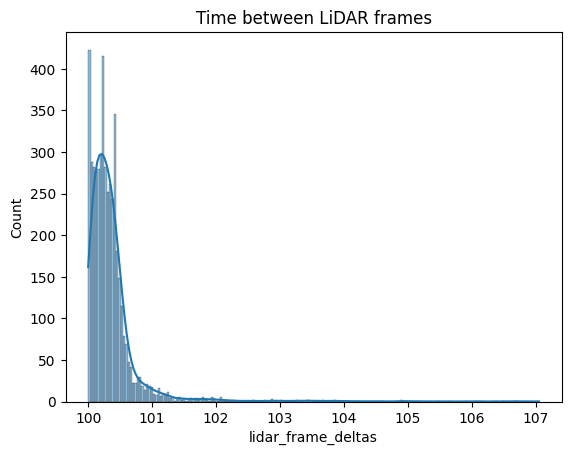

In [9]:
# Plot lidar time delta distribution
plot = sns.histplot(lidar_dataframe['lidar_frame_deltas'],kde=True).set_title('Time between LiDAR frames')
figure = plot.get_figure()
figure.savefig("TimeBTLidarFrames.svg")
print("Number of lidar frames: " + str(len(lidar_dataframe.index)) + ", Average time delta: " + str(lidar_dataframe['lidar_frame_deltas'].mean()))

In [15]:
"""
Add IMU data to dataframe
"""
imuframe = pd.read_csv('IMUFRAME.csv')
"""
imu_file = 'test_imu.csv'
rawimu = open(imu_file,'r')

gyro_data = []
accel_data = []

line = rawimu.readline()
line = rawimu.readline()    # Get rid of first 2 empty lines written by realsense tool
line = rawimu.readline()
while(line != '\n'):
    gyro_data.append(line.replace('\n','').split(','))
    line = rawimu.readline()

line = rawimu.readline()
line = rawimu.readline()
while(line):
    accel_data.append(line.replace('\n','').split(','))
    line = rawimu.readline()

gyroframe = pd.DataFrame(gyro_data[1:],columns=gyro_data[0])
gyroframe['Backend Timestamp(ms)'] = gyroframe['Backend Timestamp(ms)'].astype(np.int64).apply(lambda x: pd.to_datetime(x,unit='ms'))
print(gyroframe)

imuframe = pd.DataFrame(accel_data[1:],columns=accel_data[0])
imuframe['Backend Timestamp(ms)'] = imuframe['Backend Timestamp(ms)'].astype(np.int64).apply(lambda x: pd.to_datetime(x,unit='ms'))
print(imuframe.dtypes)
imuframe = pd.merge_asof(imuframe,gyroframe,on='Backend Timestamp(ms)',suffixes=('_Accel','_Gyro'))
imuframe = imuframe.rename(columns={'Backend Timestamp(ms)':'Datetime'})

print(imuframe)

imuframe.to_csv('IMUFRAME.csv')
"""

"\nimu_file = 'test_imu.csv'\nrawimu = open(imu_file,'r')\n\ngyro_data = []\naccel_data = []\n\nline = rawimu.readline()\nline = rawimu.readline()    # Get rid of first 2 empty lines written by realsense tool\nline = rawimu.readline()\nwhile(line != '\n'):\n    gyro_data.append(line.replace('\n','').split(','))\n    line = rawimu.readline()\n\nline = rawimu.readline()\nline = rawimu.readline()\nwhile(line):\n    accel_data.append(line.replace('\n','').split(','))\n    line = rawimu.readline()\n\ngyroframe = pd.DataFrame(gyro_data[1:],columns=gyro_data[0])\ngyroframe['Backend Timestamp(ms)'] = gyroframe['Backend Timestamp(ms)'].astype(np.int64).apply(lambda x: pd.to_datetime(x,unit='ms'))\nprint(gyroframe)\n\nimuframe = pd.DataFrame(accel_data[1:],columns=accel_data[0])\nimuframe['Backend Timestamp(ms)'] = imuframe['Backend Timestamp(ms)'].astype(np.int64).apply(lambda x: pd.to_datetime(x,unit='ms'))\nprint(imuframe.dtypes)\nimuframe = pd.merge_asof(imuframe,gyroframe,on='Backend Timest

In [16]:
"""
Parse gps data marge with perception frame data
"""
gpsframe = pd.DataFrame()
altframe = pd.DataFrame()

times = []

latitudes = []
longitudes = []

altitudes = []
altunits = []
alttimes = []

for mode in (GET, SET, POLL):
    i = 0
    with open(gps_file, "rb") as stream:
        ubr = UBXReader(stream, quitonerror=ERR_IGNORE, parsing=True,msgmode=mode)
        for _, parsed in ubr:
            if parsed is not None:
                i += 1
                if(hasattr(parsed, 'lat')):
                    times.append(pd.to_datetime(date + str(' ' + parsed.time.strftime('%H:%M:%S'))))
                    latitudes.append(parsed.lat)
                    longitudes.append(parsed.lon)
                if(hasattr(parsed,'alt')):
                    altitudes.append(parsed.alt)
                    altunits.append(parsed.altUnit)
                    alttimes.append(pd.to_datetime(date + str(' ' + parsed.time.strftime('%H:%M:%S'))))

    #print(f'\n{i} {("GET","SET","POLL")[mode]} messages parsed\n\n')

gpsframe['Datetime'] = times
gpsframe['Latitude'] = latitudes
gpsframe['Longitude'] = longitudes

altframe['Altitude'] = altitudes
altframe['Alt Unit'] = altunits
altframe['Datetime'] = alttimes

gpsframe = pd.merge_asof(gpsframe,altframe,on='Datetime',suffixes=('_gps','_alt'))

gpsframe.to_csv('gpsdata.csv')

DEBUG TP5 dict {'payload': b'\x00'} len payload 1
DEBUG TP5 dict {'payload': b'\x00\x07\x00 2\x00\x00\x00@B\x0f\x00@B\x0f\x00\x00\x00\x00\x00\xa0\x86\x01\x00\x00\x00\x00\x00\xf7\x00\x00\x00'} len payload 32
DEBUG TP5 dict {'payload': b'\x01'} len payload 1
DEBUG TP5 dict {'payload': b'\x01\x07\x00 2\x00\x00\x00\x04\x00\x00\x00\x01\x00\x00\x00H\xe8\x01\x00\xa0\x86\x01\x00\x00\x00\x00\x00\xfe\x00\x00\x00'} len payload 32


In [18]:
"""
find closest camera frame for each lidar frame and merge to single dataframe
Add GPS data
Add IMU data
"""

print("Cam frames: " + str(len(cam_dataframe.index)))
print("Lidar frames: " + str(len(lidar_dataframe.index)))

# Left hand SQL style join on lidar frames
frame_data = pd.DataFrame()
frame_data = pd.merge_asof(lidar_dataframe,cam_dataframe.sort_values('Epoch'),on='Epoch')

print("Lidar frames with no matching camera: " + str(frame_data.index.size - frame_data.dropna().index.size))
frame_data = frame_data.dropna().reset_index(drop=True)
frame_data = frame_data.rename(columns={'Datetime_x': 'Datetime'})

# Calculate time between camera and lidar timestamps
frame_data['fused_frame_deltas'] = (frame_data['Datetime'] - frame_data['Datetime_y']).dt.total_seconds()
# Match with closest gps
#frame_data = pd.merge_asof(frame_data,gpsframe,on='Datetime')
# Match with closest IMU
print(imuframe)
#frame_data = pd.merge_asof(frame_data,imuframe,on='Datetime')

# Save final dataframe to csv
frame_data.to_csv(f'framedata_{date}.csv')


Cam frames: 5987
Lidar frames: 4731
Lidar frames with no matching camera: 895
      Unnamed: 0 Stream Type_Accel  F#_Accel  HW Timestamp (ms)_Accel  \
0              0             Accel     30343                453272217   
1              1             Accel     30344                453282140   
2              2             Accel     30345                453292063   
3              3             Accel     30346                453301987   
4              4             Accel     30347                453311909   
...          ...               ...       ...                      ...   
1308        1308             Accel     31710                466836757   
1309        1309             Accel     31711                466846681   
1310        1310             Accel     31712                466856605   
1311        1311             Accel     31713                466866528   
1312        1312             Accel     31714                466876452   

                     Datetime  Host Timestamp

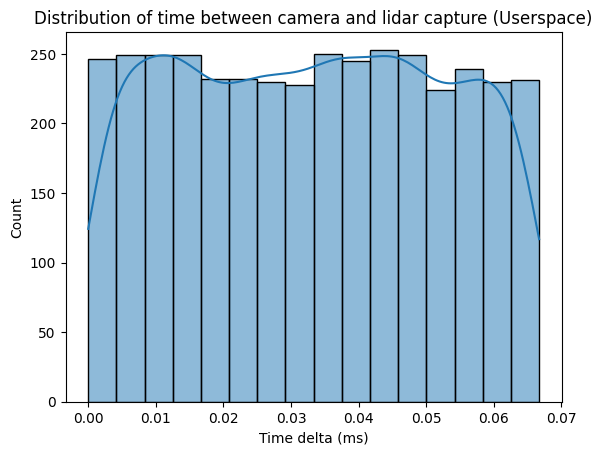

In [21]:
plot = sns.histplot(pd.Series(frame_data['fused_frame_deltas'], name="Time delta (ms)"),kde=True).set_title("Distribution of time between camera and lidar capture (Userspace)")
figure = plot.get_figure()
figure.savefig("Cam-LidUserspaceTimestampDIff.svg")

In [22]:
"""
Move camera and lidar frames to final dataset directory and rename based on index in dataset
"""

# Create export directory if does not exist
if (not os.path.exists(dest_path)):
    os.makedirs(dest_path)
if (not os.path.exists(lidar_dest)):
    os.makedirs(lidar_dest)
    os.makedirs(lidar_dest + 'data/')
if (not os.path.exists(cam_dest)):
    os.makedirs(cam_dest)
    os.makedirs(cam_dest + 'data/')
if (not os.path.exists(gps_dest)):
    os.makedirs(gps_dest)
if (not os.path.exists(gps_dest + 'data/')):
    os.makedirs(gps_dest + 'data/')

# Move matching frames to dataset directory based on index in matched dataframe
for index, row in frame_data.iterrows():    
    shutil.copy(lidar_origin + row['lidar_path'], lidar_dest + 'data/' + '{index:010d}'.format(index = index) + '.pcd')
    shutil.copy(cam_origin + row['camera_path'], cam_dest + 'data/' + '{index:010d}'.format(index = index) + '.png')
    gpspath = gps_dest + 'data/' + f'{index:010d}'.format(index = index) + '.txt'
    f = open(gpspath,'x')
    f.write(str(row['Latitude']) + ' ' + str(row['Longitude']))
    f.close()


# Create timestamps files for camera
cam_times = frame_data['Datetime_y'].to_csv(cam_dest + 'timestamps.txt',index=False,header=False)

# Create timestamps files for lidar
lidar_times = frame_data['Datetime_x'].to_csv(lidar_dest + 'timestamps.txt',index=False,header=False)

# Write GPS timestamps to file
gps_times = frame_data['Datetime_x'].to_csv(gps_dest + 'timestamps.txt',index=False,header=False)


FileExistsError: [Errno 17] File exists: '../DriveData/09-05-2024/Export/oxts/data/0000000000.txt'

In [23]:
"""
Scan camera frame metadata and compute timestamp delays
"""

# Grab all files in the camera folder
cam_files = [f for f in listdir(cam_origin) if isfile(join(cam_origin, f))]

cam_exposure_delays = []
usb_delays = []

# Iterate through metadata
for file_name in cam_files:
    # Build dictionary of data from file
    if file_name.startswith('_Color_metadata') == True:
        meta_dict = {}
        with open(cam_origin + file_name) as f:
            lines = f.readlines() # list containing lines of file
            for line in lines:
                data = [item.strip() for item in line.split(':')] # Remove whitespace after splitting
                meta_dict[data[0]] = data[1]

        # Calculate USB delay for this frame and add to list of deltas
        usb_delays.append(int(meta_dict['Time Of Arrival']) - int(meta_dict['Backend Timestamp']))
        cam_exposure_delays.append(int(meta_dict['Frame Timestamp']) - int(meta_dict['Sensor Timestamp']))


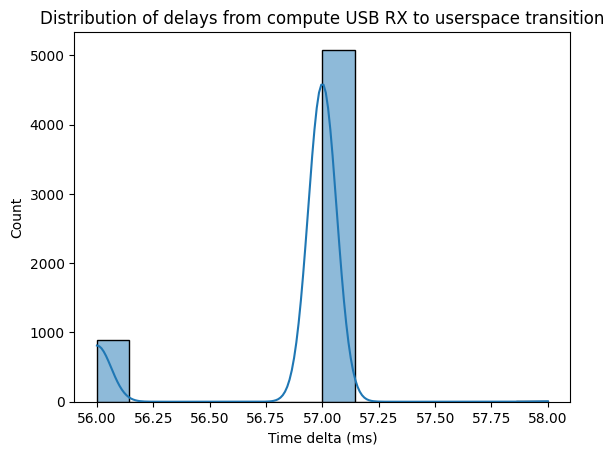

In [25]:
plot = sns.histplot(pd.Series(usb_delays, name="Time delta (ms)"),kde=True).set_title("Distribution of delays from compute USB RX to userspace transition")
figure = plot.get_figure()
figure.savefig("USBRX2UserspaceTime.svg")

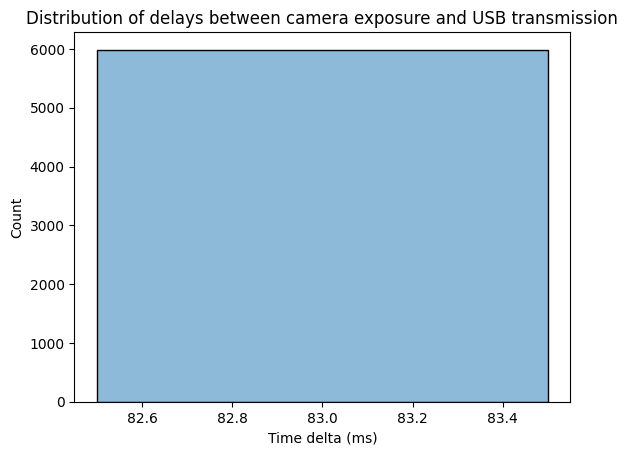

In [26]:
plot = sns.histplot(pd.Series(cam_exposure_delays, name="Time delta (ms)"),kde=True).set_title("Distribution of delays between camera exposure and USB transmission")
figure = plot.get_figure()
figure.savefig("TimeExposure2TX.svg")

delays = pd.DataFrame()
delays['Expose2usb'] = pd.DataFrame(cam_exposure_delays)
delays['Interface2userspace'] = pd.DataFrame(usb_delays)
delays.to_csv('CamDelays.csv')